In [1]:
# Libraries
import torch
import pickle
from model import BertForTokenClassification
import utils.NERutils as nu

from transformers import AutoConfig, AutoTokenizer

from torch.utils.data import DataLoader
from tqdm import tqdm

# Define tokenizer
bert_model_name = "bert-base-multilingual-cased"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

# Load data
train_path = "data/BIOtrain.parquet"
dev_path = "data/BIOdev.parquet"
test_path = "data/BIOtest.parquet"

# models_and_filters = ['Social Media','News','Web','Conversation','Wiki & Books','Legal','dannet']

# f1_scores = {model: dict() for model in models_and_filters}
FILTER = 'Legal'
model_type = 'Legal'

train_dataset = nu.NERdataset(dataset_path=train_path, tokenizer=bert_tokenizer, filter=FILTER)
dev_dataset = nu.NERdataset(dataset_path=dev_path, tokenizer=bert_tokenizer, filter=FILTER,tags=train_dataset.tags, index2tag=train_dataset.index2tag, tag2index=train_dataset.tag2index)
test_dataset = nu.NERdataset(dataset_path=test_path, tokenizer=bert_tokenizer, filter=FILTER,tags=train_dataset.tags, index2tag=train_dataset.index2tag, tag2index=train_dataset.tag2index)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
dev_loader = DataLoader(dev_dataset, batch_size=8, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=7, shuffle=False, num_workers=0)

# Set device
if torch.backends.mps.is_available():
    device = torch.device("cpu")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


# Config
bert_model_name = "bert-base-multilingual-cased"
bert_config = AutoConfig.from_pretrained(
    bert_model_name, 
    num_labels=len(train_dataset.tags), 
    id2label=train_dataset.index2tag, 
    label2id=train_dataset.tag2index
)

# initialise model
model = BertForTokenClassification.from_pretrained(bert_model_name, config=bert_config, tags=train_dataset.tags, verbose=True).to(device)

# Load model
model.load_state_dict(torch.load(f"Trained_models/source_domains/{model_type}_finetuned.pt", map_location=device))

# Evaluate model
model_preds, targets = nu.evaluate_model(model=model, dataloader=test_loader, device=device)

# Convert ids to tags
preds = [*map(train_dataset.index2tag.get, list(model_preds))]
golds = [*map(train_dataset.index2tag.get, list(targets))]

f1score = nu.getF1ScoreFromLists(golds=golds, preds=preds)

print(f1score)


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  3%|▎         | 1/35 [00:01<00:47,  1.41s/it]


KeyboardInterrupt: 

In [137]:
targets[:100]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, 22, 22, 22, 22,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 33,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 13, 13, 13, 20,
       20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [12]:
train_dataset = nu.NERdataset(dataset_path=train_path, tokenizer=bert_tokenizer, filter=FILTER)


with open("vocabs/index2tag.pkl", "wb") as f1, open("vocabs/tag2index.pkl", "wb") as f2, open("vocabs/tags.pkl", "wb") as f3:
    pickle.dump(train_dataset.index2tag, f1)
    pickle.dump(train_dataset.tag2index, f2)
    pickle.dump(train_dataset.tags, f3)


with open("vocabs/index2tag.pkl", "rb") as f1:
    print(pickle.load(f1))



{0: 'O', 1: 'B-NORP', 2: 'B-ORGANIZATION', 3: 'B-DATE', 4: 'B-FACILITY', 5: 'B-MONEY', 6: 'B-PERCENT', 7: 'B-PERSON', 8: 'I-ORGANIZATION', 9: 'B-GPE', 10: 'I-TIME', 11: 'I-MONEY', 12: 'I-ORDINAL', 13: 'B-WORK OF ART', 14: 'I-QUANTITY', 15: 'B-ORDINAL', 16: 'I-PRODUCT', 17: 'I-LAW', 18: 'I-WORK OF ART', 19: 'B-TIME', 20: 'B-LAW', 21: 'I-FACILITY', 22: 'I-LOCATION', 23: 'I-EVENT', 24: 'B-EVENT', 25: 'B-PRODUCT', 26: 'I-DATE', 27: 'I-CARDINAL', 28: 'I-PERCENT', 29: 'I-LANGUAGE', 30: 'B-QUANTITY', 31: 'I-PERSON', 32: 'B-CARDINAL', 33: 'I-GPE', 34: 'I-NORP', 35: 'B-LANGUAGE', 36: 'B-LOCATION'}


In [25]:
import pandas as pd
import pickle
models_and_filters = ['Social Media','News','Web','Conversation','Wiki & Books','Legal','dannet']

with open("f1scores_new_models.pkl", "rb") as fp:
    f1_scores_load = pickle.load(fp)

with open("f1scores_active_learning.pkl", "rb") as fp:
    f1scores_active_learning = pickle.load(fp)

with open("jaccard.pkl", "rb") as fp:
    jaccard = pickle.load(fp)

with open("similarity.pkl", "rb") as fp:
    similarity = pickle.load(fp)



FileNotFoundError: [Errno 2] No such file or directory: 'f1scores_new_models.pkl'

In [26]:
dfs = []

for model_type in models_and_filters:
    dfs.append(pd.DataFrame({'Model': [model_type]*7, 
                'Filter': f1_scores_load[model_type].keys(),
                'F1_scores': f1_scores_load[model_type].values(),
                "Similarity": similarity[model_type].values(),
                "Jaccard": jaccard[model_type].values()}))

plotting_df = pd.concat(dfs)




NameError: name 'f1_scores_load' is not defined

In [27]:


with open("f1_scores/f1scores_sourcedomainsregu_dev5.pkl", "rb") as fp:
    f1_sourceregu_dev1 = pickle.load(fp)

with open("f1_scores/f1scores_sourcedomainsregu_dev3.pkl", "rb") as fp:
    f1_sourceregu_dev2 = pickle.load(fp)


dfs = []

for model_type in models_and_filters:
    dfs.append(pd.DataFrame({'Model': [model_type]*7, 
                'Filter': f1_sourceregu_dev1[model_type].keys(),
                'F1_scores1': f1_sourceregu_dev1[model_type].values()}))

plotting_df1 = pd.concat(dfs)

dfs = []

for model_type in models_and_filters:
    dfs.append(pd.DataFrame({'Model': [model_type]*7, 
                'Filter': f1_sourceregu_dev2[model_type].keys(),
                'F1_scores2': f1_sourceregu_dev2[model_type].values()}))

plotting_df3 = pd.concat(dfs)

plotting_df = pd.merge(plotting_df3,plotting_df1, how="left", on=["Model", "Filter"])

import seaborn as sns
ax = sns.scatterplot(data=plotting_df, x="F1_scores1", y="F1_scores2", hue="Model",style="Filter")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

FileNotFoundError: [Errno 2] No such file or directory: 'f1_scores/f1scores_sourcedomainsregu_dev5.pkl'

In [28]:
def load_f1scores_from_dict(f1):

    dfs = []

    for model_type in models_and_filters:
        dfs.append(pd.DataFrame({'Model': [model_type]*7, 
                    'Filter': f1[model_type].keys(),
                    'F1_scores': f1[model_type].values()}))
    
    return pd.concat(dfs).pivot(index="Model", columns="Filter", values="F1_scores")


with open("f1_scores/f1_scores_regularized_run1.pkl", "rb") as fp:
    f1_sourceregu_dev11 = load_f1scores_from_dict(pickle.load(fp))

with open("f1_scores/f1_scores_regularized_run1_2.pkl", "rb") as fp:
    f1_sourceregu_dev12 = load_f1scores_from_dict(pickle.load(fp))

with open("f1_scores/f1_scores_regularized_run2.pkl", "rb") as fp:
    f1_sourceregu_dev21 = load_f1scores_from_dict(pickle.load(fp))

with open("f1_scores/f1_scores_regularized_run2_2.pkl", "rb") as fp:
    f1_sourceregu_dev22 = load_f1scores_from_dict(pickle.load(fp))

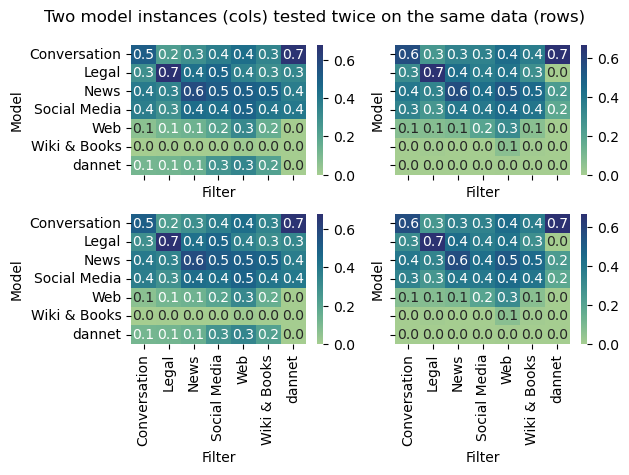

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)



sns.heatmap(f1_sourceregu_dev11, annot=True, fmt='.1f',cmap=sns.color_palette("crest", as_cmap=True), ax=ax[0,0])
sns.heatmap(f1_sourceregu_dev12, annot=True, fmt='.1f',cmap=sns.color_palette("crest", as_cmap=True), ax=ax[1,0])
sns.heatmap(f1_sourceregu_dev21, annot=True, fmt='.1f',cmap=sns.color_palette("crest", as_cmap=True), ax=ax[0,1])
sns.heatmap(f1_sourceregu_dev22, annot=True, fmt='.1f',cmap=sns.color_palette("crest", as_cmap=True), ax=ax[1,1])

plt.suptitle("Two model instances (cols) tested twice on the same data (rows)")
fig.tight_layout()

In [34]:
with open("f1_scores/f1_scores_regularized_run1.pkl", "rb") as fp:
    BL_f1 = pickle.load(fp)


In [97]:
import pickle


with open("f1_scores/f1_scores_active_learning.pkl", "rb") as fp:
    AL_f1 = pickle.load(fp)


AL_f1.update(BL_f1)


def active_learning_comparison(f1_scores: dict,target_domains:list[str]):
    dfs = []
    
    for target_domain in target_domains:
        for model in f1_scores.keys():
            if target_domain in model or model == "News":
                print(target_domain, model)
                dfs.append(pd.DataFrame({
                    "Source": [model],
                    "Target": [target_domain],
                    "Type": [model.split("_")[-1].capitalize()],
                    "F1": [f1_scores[model][target_domain]]
                }))

    return pd.concat(dfs)


active_learning_comparison(AL_f1, ["Legal", "Conversation", "Social Media", "Web"])



Legal model_News_Legal_margin
Legal model_News_Legal_confidence
Legal model_News_Legal_random
Legal News
Legal Legal
Conversation model_News_Conversation_margin
Conversation model_News_Conversation_confidence
Conversation model_News_Conversation_random
Conversation News
Conversation Conversation
Social Media model_News_Social Media_margin
Social Media model_News_Social Media_confidence
Social Media model_News_Social Media_random
Social Media Social Media
Social Media News
Web News
Web Web


,Source,Target,Type,F1
0,model_News_Legal_margin,Legal,Margin,0.524841
0,model_News_Legal_confidence,Legal,Confidence,0.438503
0,model_News_Legal_random,Legal,Random,0.540943
0,News,Legal,News,0.347305
0,Legal,Legal,Legal,0.678571
0,model_News_Conversation_margin,Conversation,Margin,0.404858
0,model_News_Conversation_confidence,Conversation,Confidence,0.462687
0,model_News_Conversation_random,Conversation,Random,0.393443
0,News,Conversation,News,0.388693
0,Conversation,Conversation,Conversation,0.507143


In [98]:
AL_f1.keys()

dict_keys(['model_News_Social Media_margin', 'model_News_Social Media_confidence', 'model_News_Social Media_random', 'model_News_Legal_margin', 'model_News_Legal_confidence', 'model_News_Legal_random', 'model_News_Conversation_margin', 'model_News_Conversation_confidence', 'model_News_Conversation_random', 'Social Media', 'News', 'Web', 'Conversation', 'Wiki & Books', 'Legal', 'dannet'])

In [31]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
dfs = []

models = ["random", "confidence", "margin"]
filters = ['Social Media','News','Web','Conversation','Wiki & Books','Legal','dannet']

for model_type in models:
    dfs.append(pd.DataFrame({'Model': [model_type]*7, 
                'Filter': f1scores_active_learning[model_type].keys(),
                'F1_scores': f1scores_active_learning[model_type].values()}))

f1_df = pd.concat(dfs).pivot(index="Model", columns="Filter", values="F1_scores")


sns.heatmap(f1_df,annot=True, fmt='.1f',cmap=sns.color_palette("crest", as_cmap=True))
plt.title("Active learning models tested on test data, spanf1")


NameError: name 'f1scores_active_learning' is not defined

In [81]:
train = nu.readDataset(train_path)
train.groupby("dagw_domain").count()[["text"]]



,text
dagw_domain,
Conversation,1020
Legal,1690
News,346
Social Media,439
Web,6661
Wiki & Books,1361
dannet,18


In [105]:

train_dataset = nu.NERdataset("data/BIOtrain.parquet", tokenizer=bert_tokenizer)

NameError: name 'train_dataset' is not defined

In [4]:
print("[", end="")
for td in ["Social Media", "Legal", "Conversation"]:
    for qs in ["margin", "confidence", "random"]:
        print(f'"model_News_{td}_{qs}",')
print("]")



["model_News_Social Media_margin",
"model_News_Social Media_confidence",
"model_News_Social Media_random",
"model_News_Legal_margin",
"model_News_Legal_confidence",
"model_News_Legal_random",
"model_News_Conversation_margin",
"model_News_Conversation_confidence",
"model_News_Conversation_random",
]


# F1 score vs. pct of data used

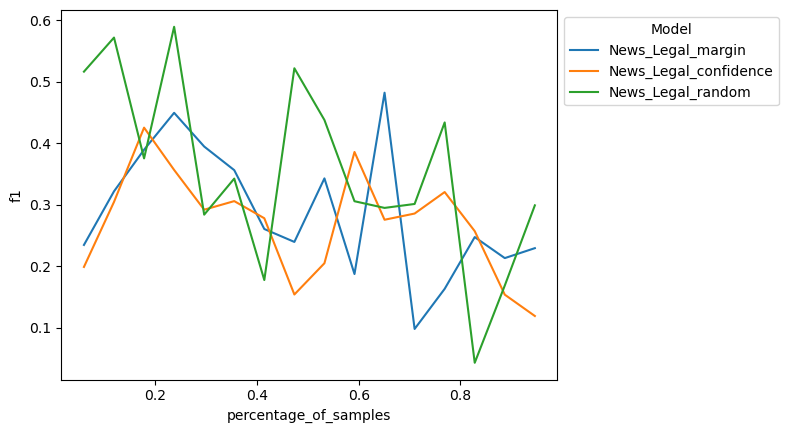

In [91]:
dfs = []

for model in AL_f1.keys():
    if "model" in model and "L" in model:
        s,t,q = model.split("_")[1:]
        df = pd.read_csv(f"al_results/ALResult_{s}_{t}_{q}.csv")
        df["Model"] = f"{s}_{t}_{q}"
        dfs.append(df)


fig,ax=plt.subplots()

sns.lineplot(data = pd.concat(dfs), x="percentage_of_samples", y="f1", hue="Model")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

